# Телеком

**Прогнозирование оттока клиентов в телекоммуникационной компании.**

Клиентам, собирающимся уйти, будут предложены прокомокды и специальные условия.

**Описание услуг оператора:**

1. Стационарная телефонная связь. Возможно подключение аппарата к нескольким линиям одновременно.
2. Интернет. DSL или оптоволокно.

Доп. услуги:

* Интернет безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity)
* Выделенная линия тех. поддержки (TechSupport)
* Облачное хранилище файлов для резервного копирования (OnlineBackup)
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies)

**Оплата услуг клиентами:**
* Оплата каждый месяц
* Договор на 1-2 года  

Доступны различные способы расчета и возможность получения электронного чека.



## Импорты

In [3]:
import os
from dotenv import load_dotenv

from sqlalchemy import create_engine 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from catboost import CatBoostClassifier
import catboost as cb

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchmetrics import AUROC

from tqdm import tqdm

import optuna

import shap

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')

In [4]:
shap.initjs()

In [5]:
RAND_STATE = 42

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Описание и загрузка данных
БД: `PostgeSQL`

Таблицы:
* `contract` - информация о договоре
* `personal` - персональные данные клиента
* `internet` - информация об интернет-услугах
* `phone` - информация об услугах телефонии

Информация о договорах актуальна на 1 февраля 2020.

Каждую таблицу отдельно рассмотрим ниже.

In [ ]:
# Подключение в БД

load_dotenv('db_config.env')

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    os.getenv('USER'),
    os.getenv('PWD'),
    os.getenv('HOST'),
    os.getenv('PORT'),
    os.getenv('DB'),
) 

engine = create_engine(connection_string) 

### Таблица `telecom.contract` - информация о договоре

* `customerID` — ID пользователя,
* `BeginDate` — дата начала действия,
* `EndDate` — дата окончания действия,
* `Type` — тип оплаты (раз в год или помесячно),
* `PaperlessBilling` — безбумажный расчётный лист,
* `PaymentMethod` — тип платежа,
* `MonthlyCharges` — расход за месяц,
* `TotalCharges` — общие расходы.

In [8]:
query = '''
SELECT *
FROM telecom.contract
--LIMIT 5
'''
contract = pd.read_sql_query(query,con=engine)

# Сразу переведем дату в соответствующий тип данных
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'],format='%Y-%m-%d')
contract['EndDate'] = pd.to_datetime(contract['EndDate'],format='%Y-%m-%d')

contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


In [9]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


Только у 1869 пользователей есть дата окончания действия.  
Есть пропуски в `'TotalCharges'`.

In [10]:
contract['customerID'].nunique()

7043

In [11]:
contract['BeginDate'].describe(datetime_is_numeric=True)

count                             7043
mean     2019-03-20 03:51:02.274599168
min                2018-04-17 00:00:00
25%                2019-01-18 12:00:00
50%                2019-03-22 00:00:00
75%                2019-05-21 00:00:00
max                2020-02-01 00:00:00
Name: BeginDate, dtype: object

Дата начала действия от `2018-04-17` до `2020-02-01`.

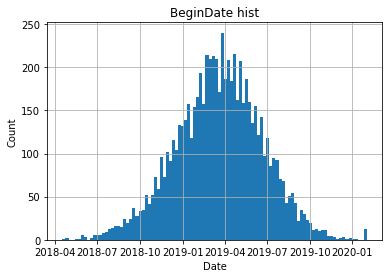

In [12]:
contract['BeginDate'].hist(bins=100)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('BeginDate hist')
plt.show()

Распределение этих дат похоже на нормальное, только последнее значение похоже на какой-то небольшой спайк. Данные младше 2020-02-01 были переназначены на 2020-02-01?

In [13]:
contract['EndDate'].describe(datetime_is_numeric=True)

count                             1869
mean     2019-11-15 21:31:18.009630720
min                2019-10-01 00:00:00
25%                2019-11-01 00:00:00
50%                2019-11-01 00:00:00
75%                2019-12-01 00:00:00
max                2020-01-01 00:00:00
Name: EndDate, dtype: object

In [14]:
contract['EndDate'].value_counts()

2019-11-01    485
2019-12-01    466
2020-01-01    460
2019-10-01    458
Name: EndDate, dtype: int64

Только 4 значения: октябрь, ноябрь, декабрь 19 года и январь 20.

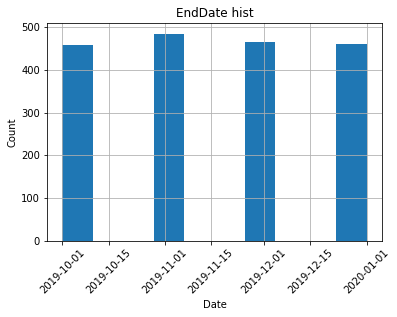

In [15]:
contract['EndDate'].hist(bins=10)
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('EndDate hist')
plt.show()

In [16]:
contract['Type'].value_counts(dropna=False)

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

Типы оплаты: помесячно, двухгодовая оплата, годовая оплата.

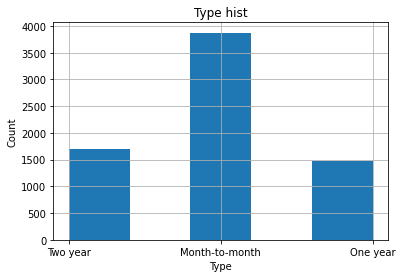

In [17]:
contract['Type'].hist(bins=5)
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Type hist')
plt.show()

In [18]:
contract['PaperlessBilling'].value_counts(dropna=False)

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

Пользуются или не пользуются электронным чеком.

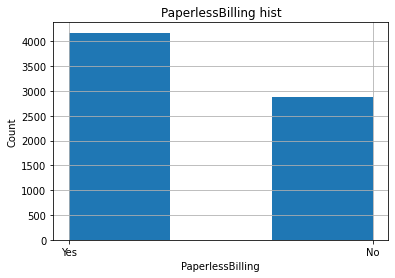

In [19]:
contract['PaperlessBilling'].hist(bins=3)
plt.xlabel('PaperlessBilling')
plt.ylabel('Count')
plt.title('PaperlessBilling hist')
plt.show()

In [20]:
contract['PaymentMethod'].value_counts(dropna=False)

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

Способы оплаты:
* `Electronic check` - электронный чек (инвоис ?)
* `Mailed check` - инвоис по почте
* `Bank transfer (automatic)` - автоматический банковский перевод
* `Credit card (automatic)` - автоматическая оплата кредитной картой

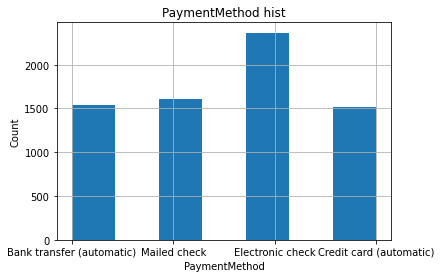

In [21]:
contract['PaymentMethod'].hist(bins=7)
plt.xlabel('PaymentMethod')
# plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('PaymentMethod hist')
plt.show()

In [22]:
contract['MonthlyCharges'].isna().sum()

0

In [23]:
contract['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

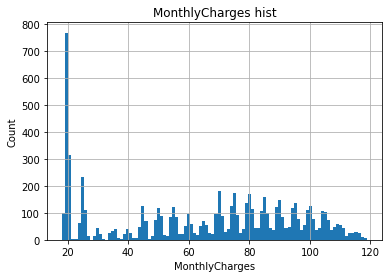

In [24]:
contract['MonthlyCharges'].hist(bins=100)
plt.xlabel('MonthlyCharges')
# plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('MonthlyCharges hist')
plt.show()

Здесь, видимо, такое распределения из-за большого кол-ва услуг, которые стоят по-разному и в разных сочетаниях.

In [25]:
contract['TotalCharges'].nunique()

6530

In [26]:
contract['TotalCharges'].describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

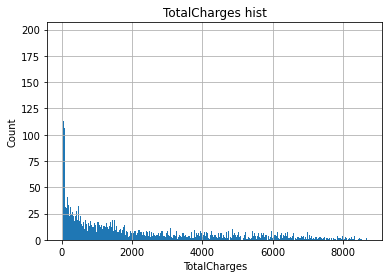

In [27]:
contract['TotalCharges'].hist(bins=1000)
plt.xlabel('TotalCharges')
# plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('TotalCharges hist')
plt.show()

### Таблица `telecom.personal` - персональные данные клиента

* `customerID` — ID пользователя,
* `gender` — пол,
* `SeniorCitizen` — является ли абонент пенсионером,
* `Partner` — есть ли у абонента супруг/супруга,
* `Dependents` — есть ли у абонента дети.

In [28]:
query = """
SELECT *
FROM telecom.personal
--LIMIT 5
"""

personal = pd.read_sql_query(query,con=engine)

In [29]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [30]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [31]:
personal['customerID'].nunique()

7043

In [32]:
np.where(contract['customerID'].sort_values(kind='stable').values == personal['customerID'].sort_values(kind='stable').values , 1, 0).sum()

7043

Столбцы с айдишником одинаковые и в `contract` и в `personal`.

In [33]:
personal['gender'].value_counts(dropna=False)

Male      3555
Female    3488
Name: gender, dtype: int64

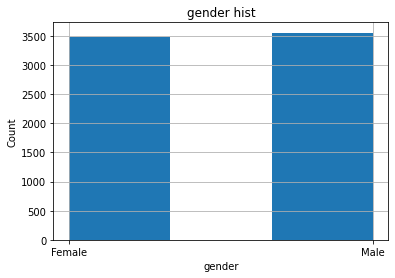

In [34]:
personal['gender'].hist(bins=3)
plt.xlabel('gender')
# plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('gender hist')
plt.show()

In [35]:
personal['SeniorCitizen'].value_counts(dropna=False)

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

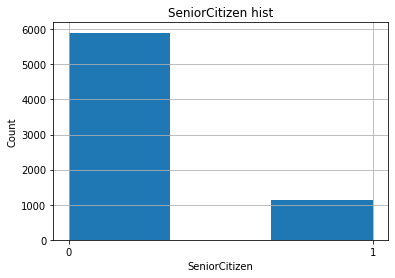

In [36]:
personal['SeniorCitizen'].hist(bins=3)
plt.xlabel('SeniorCitizen')
# plt.xticks(rotation=45)
plt.xticks([0,1])
plt.ylabel('Count')
plt.title('SeniorCitizen hist')
plt.show()

In [37]:
personal['Partner'].value_counts(dropna=False)

No     3641
Yes    3402
Name: Partner, dtype: int64

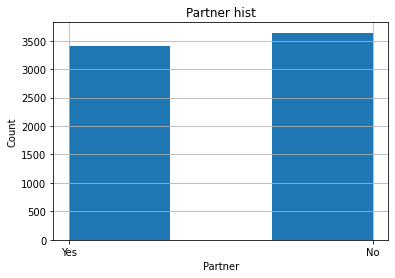

In [38]:
personal['Partner'].hist(bins=3)
plt.xlabel('Partner')
# plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('Partner hist')
plt.show()

In [39]:
personal['Dependents'].value_counts(dropna=False)

No     4933
Yes    2110
Name: Dependents, dtype: int64

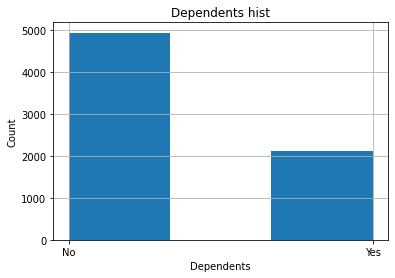

In [40]:
personal['Dependents'].hist(bins=3)
plt.xlabel('Dependents')
# plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('Dependents hist')
plt.show()

### Таблица `telecom.internet` - информация об интернет-услугах

* `customerID` — ID пользователя,
* `InternetService` — тип подключения,
* `OnlineSecurity` — блокировка небезопасных сайтов,
* `OnlineBackup` — облачное хранилище файлов для резервного копирования данных,
* `DeviceProtection` — антивирус,
* `TechSupport` — выделенная линия технической поддержки,
* `StreamingTV` — стриминговое телевидение,
* `StreamingMovies` — каталог фильмов.

In [41]:
# В этой таблице первой строкой идет корректные названия столбцов
# Поэтому вытащим эту строку в отдельный список
query = """
SELECT *
FROM telecom.internet
LIMIT 1

"""

col_names = pd.read_sql_query(query,con=engine).loc[0].tolist()

In [42]:
query = """
SELECT *
FROM telecom.internet
--LIMIT 5
OFFSET 1
"""

internet = pd.read_sql_query(query,con=engine)
internet.columns = col_names
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [43]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Кол-во пользователей меньше. Не все пользуются интернет-услугами.

In [44]:
internet['customerID'].isin(contract['customerID']).sum()

5517

In [45]:
internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

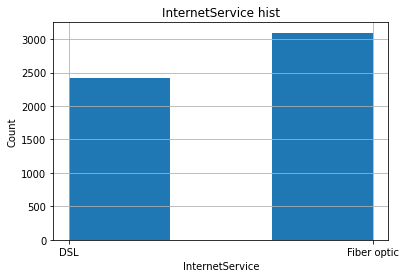

In [46]:
internet['InternetService'].hist(bins=3)
plt.xlabel('InternetService')
# plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('InternetService hist')
plt.show()

In [47]:
internet['OnlineSecurity'].value_counts()

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

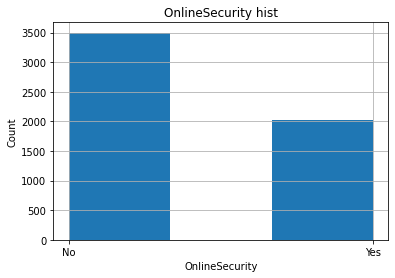

In [48]:
internet['OnlineSecurity'].hist(bins=3)
plt.xlabel('OnlineSecurity')
# plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('OnlineSecurity hist')
plt.show()

In [49]:
internet['OnlineBackup'].value_counts()

No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

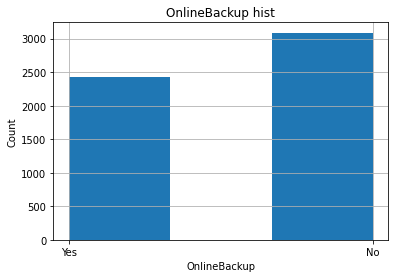

In [50]:
internet['OnlineBackup'].hist(bins=3)
plt.xlabel('OnlineBackup')
# plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('OnlineBackup hist')
plt.show()

In [51]:
internet['DeviceProtection'].value_counts()

No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

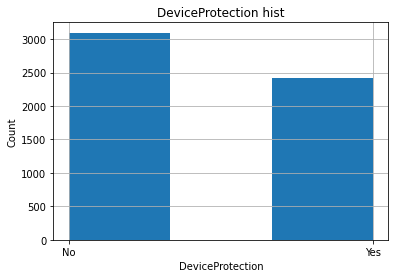

In [52]:
internet['DeviceProtection'].hist(bins=3)
plt.xlabel('DeviceProtection')
# plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('DeviceProtection hist')
plt.show()

In [53]:
internet['TechSupport'].value_counts()

No     3473
Yes    2044
Name: TechSupport, dtype: int64

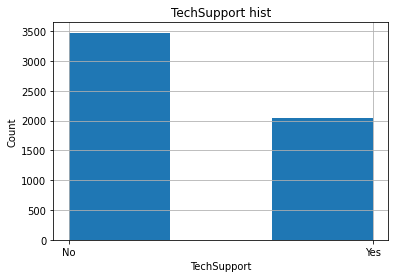

In [54]:
internet['TechSupport'].hist(bins=3)
plt.xlabel('TechSupport')
# plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('TechSupport hist')
plt.show()

In [55]:
internet['StreamingTV'].value_counts()

No     2810
Yes    2707
Name: StreamingTV, dtype: int64

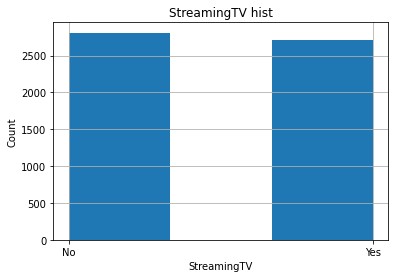

In [56]:
internet['StreamingTV'].hist(bins=3)
plt.xlabel('StreamingTV')
# plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('StreamingTV hist')
plt.show()

In [57]:
internet['StreamingMovies'].value_counts()

No     2785
Yes    2732
Name: StreamingMovies, dtype: int64

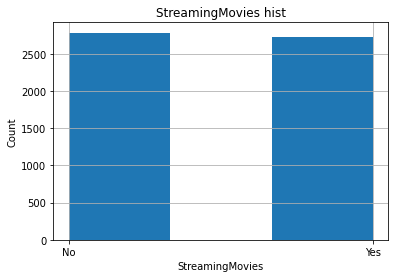

In [58]:
internet['StreamingMovies'].hist(bins=3)
plt.xlabel('StreamingMovies')
# plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('StreamingMovies hist')
plt.show()

### Таблица `telecom.phone` - информация об услугах телефонии

* `customerID` — ID пользователя,
* `MultipleLines` — подключение телефонного аппарата к нескольким линиям одновременно.

In [59]:
# В этой таблице первой строкой идет корректные названия столбцов
# Поэтому вытащим эту строку в отдельный список
query = """
SELECT *
FROM telecom.phone
LIMIT 1

"""

col_names = pd.read_sql_query(query,con=engine).loc[0].tolist()

In [60]:
query = """
SELECT *
FROM telecom.phone
--LIMIT 5
OFFSET 1
"""

phone = pd.read_sql_query(query,con=engine)
phone.columns = col_names
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [61]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [62]:
phone['customerID'].isin(contract['customerID']).sum()

6361

In [63]:
phone['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

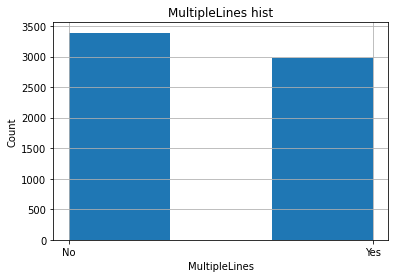

In [64]:
phone['MultipleLines'].hist(bins=3)
plt.xlabel('MultipleLines')
# plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('MultipleLines hist')
plt.show()

## Data merging

Объединим данные в один датафрейм и добавим признаков.

In [65]:
df = contract.merge(personal,on='customerID',how='outer').merge(internet,on='customerID',how='outer').merge(phone,on='customerID',how='outer')

In [66]:
df.head(2)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
1,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

Добавим кол-во дней <!-- месяцев --> с `BeginDate` до `EndDate`. Пропуски в `EndDate` заполним `2020-02-01`.

In [68]:
# df['month_delta'] = (df['EndDate'].fillna(pd.Timestamp('20200201')) - df["BeginDate"]).dt.days // 30
df['days_delta'] = (df['EndDate'].fillna(pd.Timestamp('20200201')) - df["BeginDate"]).dt.days
df['days_delta']

0         0
1         0
2       479
3         0
4       279
       ... 
7038    376
7039    340
7040    152
7041    220
7042    289
Name: days_delta, Length: 7043, dtype: int64

Добавим столбцы "пользователь интернета" и "пользователь телефонии"

In [69]:
# df['internet_user'] = np.where(df['InternetService'] != 'NA', 1,0)
# df['phone_user'] = np.where(df['MultipleLines'] != 'NA', 1,0)

df['internet_user'] = df['InternetService'].notna().astype('int8')
df['phone_user'] = df['MultipleLines'].notna().astype('int8')

In [70]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,days_delta,internet_user,phone_user
0,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,...,Yes,No,Yes,Yes,Yes,No,NaN,0,1,0
1,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0,1
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,Yes,Yes,No,No,No,No,No,479,1,1
3,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN,Female,0,...,Yes,Yes,Yes,No,Yes,Yes,No,0,1,1
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,No,No,No,No,No,No,279,1,1


Сделаем таргет: `'churned'`.

In [71]:
df['churned'] = df['EndDate'].notna().astype('int8')

In [72]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,days_delta,internet_user,phone_user,churned
0,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,...,No,Yes,Yes,Yes,No,NaN,0,1,0,0
1,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN,Male,0,...,NaN,NaN,NaN,NaN,NaN,No,0,0,1,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,Yes,No,No,No,No,No,479,1,1,1
3,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN,Female,0,...,Yes,Yes,No,Yes,Yes,No,0,1,1,0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,No,No,No,No,No,279,1,1,1


In [73]:
df['churned'].value_counts()

0    5174
1    1869
Name: churned, dtype: int64

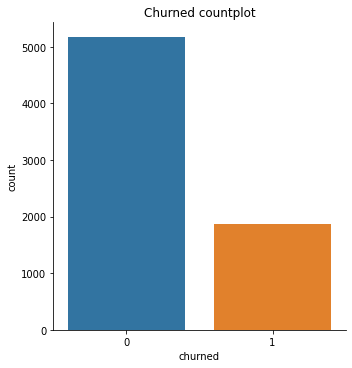

In [74]:
sns.catplot(kind='count',data=df,x='churned')
plt.title('Churned countplot')
plt.show()

Видим дисбаланс классов.

In [75]:
# # У тех клиентов, кто не пользовался услугами интернета или телефонии заполним пропуски 'NA'
# cols_to_fillna = ['InternetService',
#                   'OnlineSecurity',
#                   'OnlineBackup',
#                   'DeviceProtection',
#                   'TechSupport',
#                   'StreamingTV',
#                   'StreamingMovies',
#                   'MultipleLines']

# # df[cols_to_fillna] = df[cols_to_fillna].fillna('NA')

Не будем заполнять пропуски, чтобы правильно провести анализ.

In [76]:
df['PaperlessBilling'] = df['PaperlessBilling'].replace(['Yes','No'],[1,0])
df['gender'] = df['gender'].replace(['Male','Female'],[1,0])
df['Partner'] = df['Partner'].replace(['Yes','No'],[1,0])
df['Dependents'] = df['Dependents'].replace(['Yes','No'],[1,0])
df['OnlineSecurity'] = df['OnlineSecurity'].replace(['Yes','No','NA'],[1,0,-1])
df['OnlineBackup'] = df['OnlineBackup'].replace(['Yes','No','NA'],[1,0,-1])
df['DeviceProtection'] = df['DeviceProtection'].replace(['Yes','No','NA'],[1,0,-1])
df['TechSupport'] = df['TechSupport'].replace(['Yes','No','NA'],[1,0,-1])
df['StreamingTV'] = df['StreamingTV'].replace(['Yes','No','NA'],[1,0,-1])
df['StreamingMovies'] = df['StreamingMovies'].replace(['Yes','No','NA'],[1,0,-1])
df['MultipleLines'] = df['MultipleLines'].replace(['Yes','No','NA'],[1,0,-1])

In [77]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,days_delta,internet_user,phone_user,churned
0,4472-LVYGI,2020-02-01,NaT,Two year,1,Bank transfer (automatic),52.55,NaN,0,0,...,0.0,1.0,1.0,1.0,0.0,NaN,0,1,0,0
1,3115-CZMZD,2020-02-01,NaT,Two year,0,Mailed check,20.25,NaN,1,0,...,NaN,NaN,NaN,NaN,NaN,0.0,0,0,1,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,479,1,1,1
3,5709-LVOEQ,2020-02-01,NaT,Two year,0,Mailed check,80.85,NaN,0,0,...,1.0,1.0,0.0,1.0,1.0,0.0,0,1,1,0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,279,1,1,1


**'TotalCharges'**

Попробуем заполнить пропуски в TotalCharges и проверим как они считаются.

In [78]:
df['TotalCharges'].isna().sum()

11

In [79]:
df.iloc[2,:8]#.to_frame().T

customerID                   3668-QPYBK
BeginDate           2018-08-09 00:00:00
EndDate             2019-12-01 00:00:00
Type                     Month-to-month
PaperlessBilling                      1
PaymentMethod              Mailed check
MonthlyCharges                    53.85
TotalCharges                     108.15
Name: 2, dtype: object

In [80]:
108.15/53.85

2.0083565459610027

`'TotalCharges'` в 2 раза больше `'MontlyCharges'`, но с `'BeginDate'` до `'EndDate'` прошло больше 2х месяцев. Как считается `'TotalCharges'`?

In [81]:
temp = df.loc[df['TotalCharges'].notna()]
temp['EndDate'] = temp['EndDate'].fillna(pd.Timestamp('20200201'))
temp['date_delta'] = temp['EndDate'] - temp['BeginDate']
temp['months_delta'] = temp['date_delta'].dt.days // 30
temp['charges_n'] = temp['TotalCharges'] / temp['MonthlyCharges']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [82]:
temp

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,StreamingTV,StreamingMovies,MultipleLines,days_delta,internet_user,phone_user,churned,date_delta,months_delta,charges_n
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,0,...,0.0,0.0,0.0,479,1,1,1,479 days,15,2.008357
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,0,0,...,0.0,0.0,0.0,279,1,1,1,279 days,9,2.144979
5,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,1,Electronic check,99.65,820.50,0,0,...,1.0,1.0,1.0,310,1,1,1,310 days,10,8.233818
8,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,1,Electronic check,104.80,3046.05,0,0,...,1.0,1.0,1.0,188,1,1,1,188 days,6,29.065363
12,0280-XJGEX,2018-11-13,2019-10-01,Month-to-month,1,Bank transfer (automatic),103.70,5036.30,1,0,...,1.0,1.0,1.0,322,1,1,1,322 days,10,48.566056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,2020-02-01,Two year,1,Bank transfer (automatic),21.15,1419.40,0,0,...,NaN,NaN,0.0,376,0,1,0,376 days,12,67.111111
7039,6840-RESVB,2019-02-26,2020-02-01,One year,1,Mailed check,84.80,1990.50,1,0,...,1.0,1.0,1.0,340,1,1,0,340 days,11,23.472877
7040,2234-XADUH,2019-09-02,2020-02-01,One year,1,Credit card (automatic),103.20,7362.90,0,0,...,1.0,1.0,1.0,152,1,1,0,152 days,5,71.345930
7041,4801-JZAZL,2019-06-26,2020-02-01,Month-to-month,1,Electronic check,29.60,346.45,0,0,...,0.0,0.0,NaN,220,1,0,0,220 days,7,11.704392


Вопрос: "Как считается `'TotalCharges'`?" нужно выяснить у заказчика.  
Удалим строки с пропусками в `'TotalCharges'`.

In [83]:
print(df.shape)
df = df.dropna(subset=['TotalCharges'])
print(df.shape)


(7043, 24)
(7032, 24)


## EDA

**'MonthlyCharges'**

In [84]:
pd.concat([df['MonthlyCharges'].describe(),df.groupby('churned')['MonthlyCharges'].describe().T],axis=1)

,MonthlyCharges,0,1
count,7032.000000,5163.000000,1869.000000
mean,64.798208,61.307408,74.441332
std,30.085974,31.094557,24.666053
min,18.250000,18.250000,18.850000
25%,35.587500,25.100000,56.150000
50%,70.350000,64.450000,79.650000
75%,89.862500,88.475000,94.200000
max,118.750000,118.750000,118.350000


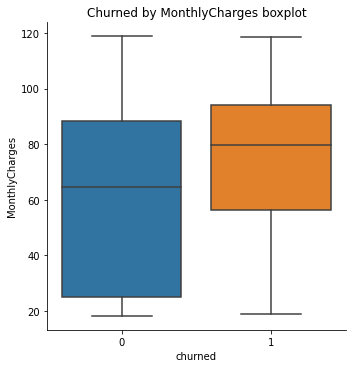

In [85]:
sns.catplot(kind='box',data=df,x='churned',y='MonthlyCharges');
plt.title('Churned by MonthlyCharges boxplot')
plt.show()

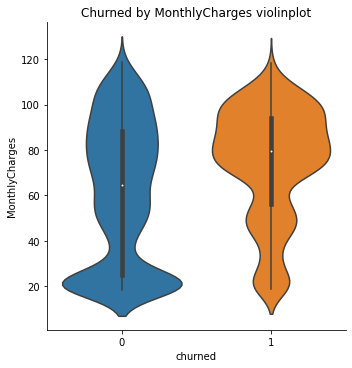

In [86]:
sns.catplot(kind='violin',data=df,x='churned',y='MonthlyCharges')
plt.title('Churned by MonthlyCharges violinplot')
plt.show()

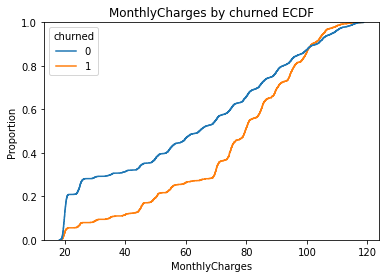

In [87]:
sns.ecdfplot(data=df,x='MonthlyCharges',hue='churned');
plt.title('MonthlyCharges by churned ECDF')
plt.show()

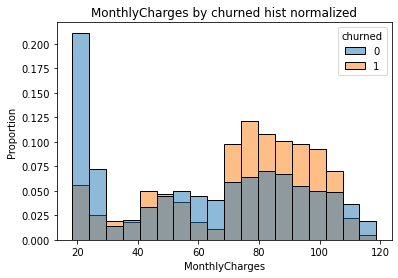

In [88]:
sns.histplot(data=df,x='MonthlyCharges',hue='churned',stat='proportion',common_norm=False);
plt.title('MonthlyCharges by churned hist normalized')
plt.show()

Видим, что у не-оттока велика доля небольших ежемесячных платежей.  
А у оттока выше доля от 70 до ~105, чем у не-оттока при отдельной нормализации каждой группы.

Посмотрим долю пользователей интернета и телефонии в группах оттока и не-оттока.

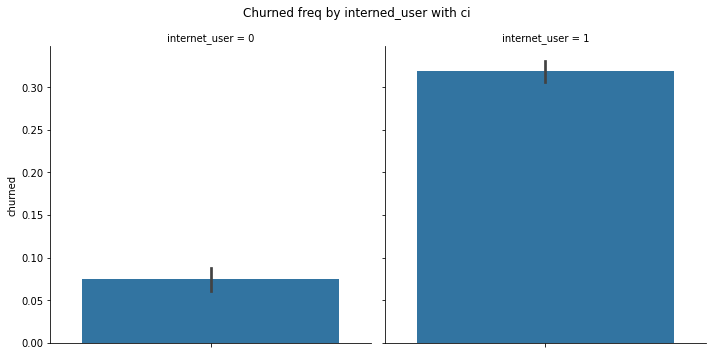

In [89]:
ax = sns.catplot(kind='bar',data=df,y='churned',col='internet_user');
ax.fig.subplots_adjust(top=0.87)
ax.fig.suptitle('Churned freq by interned_user with ci')
plt.show()

В группе пользователей интернета доля оттока на 25% больше, чем в группе не-пользователей. 

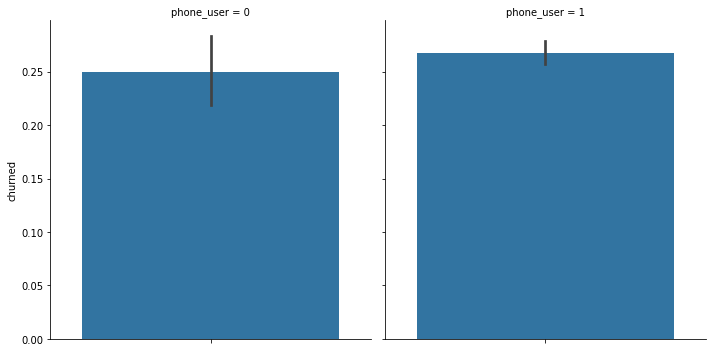

In [90]:
sns.catplot(kind='bar',data=df,y='churned',col='phone_user')
ax.fig.subplots_adjust(top=0.87)
ax.fig.suptitle('Churned freq by phone_user with ci')
plt.show()

В группах пользующихся телефонией и не-пользующихся - доля уходящих в отток примерно одинакова.

**Матрица корреляции**

In [91]:
df.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines', 'days_delta',
       'internet_user', 'phone_user', 'churned'],
      dtype='object')

In [92]:
df.corr()

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,days_delta,internet_user,phone_user,churned
PaperlessBilling,1.000000,0.351930,0.157830,-0.011902,0.156258,-0.013957,-0.110131,-0.139195,0.006299,-0.022803,-0.088187,0.118822,0.101048,0.174509,-0.019359,0.320592,0.016696,0.191454
MonthlyCharges,0.351930,1.000000,0.651065,-0.013779,0.219874,0.097825,-0.112343,0.069771,0.252683,0.322484,0.135067,0.533069,0.525303,0.456642,-0.015740,0.763191,0.248033,0.192858
TotalCharges,0.157830,0.651065,1.000000,0.000048,0.102411,0.319072,0.064653,0.331783,0.431750,0.446978,0.354257,0.430234,0.434399,0.466612,-0.016204,0.374878,0.113008,-0.199484
gender,-0.011902,-0.013779,0.000048,1.000000,-0.001819,-0.001379,0.010349,-0.017665,-0.013786,0.001218,-0.008291,-0.006400,-0.010098,-0.007432,0.007914,-0.004745,-0.007515,-0.008545
SeniorCitizen,0.156258,0.219874,0.102411,-0.001819,1.000000,0.016957,-0.210550,-0.110155,-0.003253,-0.011162,-0.135289,0.034150,0.050055,0.153747,-0.000244,0.182519,0.008392,0.150541
Partner,-0.013957,0.097825,0.319072,-0.001379,0.016957,1.000000,0.452269,0.171581,0.173154,0.187386,0.144021,0.154387,0.146731,0.150561,-0.013795,0.000286,0.018397,-0.149982
Dependents,-0.110131,-0.112343,0.064653,0.010349,-0.210550,0.452269,1.000000,0.157478,0.096695,0.084184,0.136108,0.052660,0.025177,-0.026310,-0.000581,-0.138383,-0.001078,-0.163128
OnlineSecurity,-0.139195,0.069771,0.331783,-0.017665,-0.110155,0.171581,0.157478,1.000000,0.179488,0.170099,0.273270,0.043613,0.056238,0.053949,-0.014058,NaN,-0.037132,-0.280508
OnlineBackup,0.006299,0.252683,0.431750,-0.013786,-0.003253,0.173154,0.096695,0.179488,1.000000,0.185021,0.190381,0.146821,0.137064,0.162362,-0.019466,NaN,0.014632,-0.195758
DeviceProtection,-0.022803,0.322484,0.446978,0.001218,-0.011162,0.187386,0.084184,0.170099,0.185021,1.000000,0.235564,0.275900,0.289547,0.170136,-0.019426,NaN,-0.005223,-0.176806


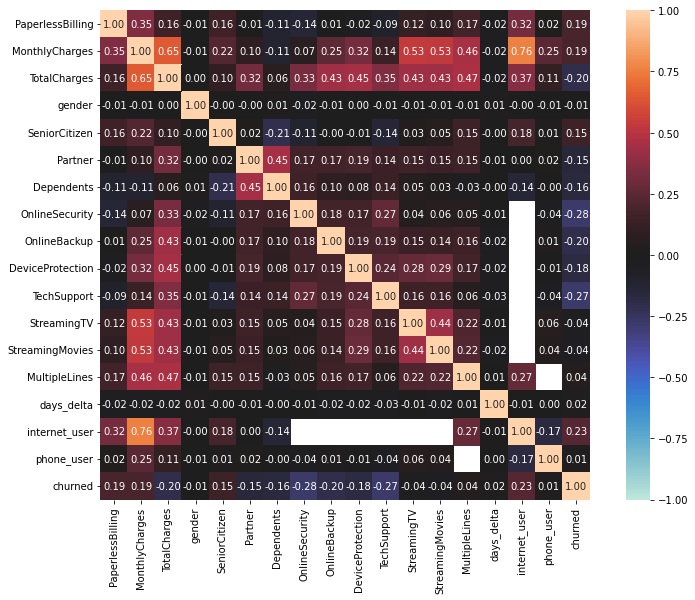

In [93]:
plt.figure(figsize=(13,9))
sns.heatmap(df.corr(numeric_only=True),
            vmin=-1,
            vmax=1,
            center=0,
            annot=True,
            fmt='.2f',
            square=True
           )
plt.show()

* `churned` коррелирует со всем понемногу - может сработать линейная модель
* Пользование интернетом коррелирует с ежемесячными платежами. Видимо, интернет сильно дороже телефонии отдельно, либо в совокупности с доп. услугами.
* Ежемесячные платежи коррелирует с TotalCharges, что предсказуемо, но не ясно как TotalCharges считается.
* TotalCharges средне коррелирует с доп. услугами, что ожидаемо.

Здесь еще стоит попробовать Phik корреляцию: https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7

In [94]:
# sns.pairplot(df,x_vars='churned',kind='kde')

## Выбор модели

Проверим 4 модели:
* Логистическая регрессия
* Дерево решений
* Catboost
* Нейронную сеть

В качестве метрики качества будем использова AUC ROC.  
Задача: получить метрику больше 0.78

In [95]:
# Create year,month,day from dates?

In [96]:
# Удалим таргет, айди пользователя и даты из признаков
# Дропнем пропуски в TotalCharges, поскольку не знаем как они строятся + их всего 12
# Заполним пропуски в доп услугах 'NA'
X = df.drop(columns=['churned','customerID','BeginDate','EndDate'])

y = df['churned']

Заполним пропуски 0 или 'NA'.

In [97]:
X.isna().sum()

Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1520
OnlineSecurity      1520
OnlineBackup        1520
DeviceProtection    1520
TechSupport         1520
StreamingTV         1520
StreamingMovies     1520
MultipleLines        680
days_delta             0
internet_user          0
phone_user             0
dtype: int64

In [98]:
X['InternetService'] = X['InternetService'].fillna('NA')

In [99]:
X = X.fillna(0)

In [100]:
X.isna().sum().sum()

0

Сохраним названия категориальных и численных признаков.

In [101]:
cat_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 
                'gender', 'SeniorCitizen', 'Partner', 
                'Dependents','InternetService', 'OnlineSecurity', 
                'OnlineBackup', 'DeviceProtection','TechSupport', 
                'StreamingTV', 'StreamingMovies', 'MultipleLines', 
                'internet_user', 'phone_user']

num_features = ['MonthlyCharges','TotalCharges','days_delta']

В категориальных признаках изменим флоаты на инты.

In [102]:
X[X[cat_features].select_dtypes('float').columns] = X[X[cat_features].select_dtypes('float').columns].astype('str')

Разделим датасет на тренировочный и валидационный.

In [103]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=RAND_STATE,test_size=0.2,shuffle=True,stratify=y)

In [104]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((5625, 20), (1407, 20), (5625,), (1407,))

**LogisticRegression**

Для логистической регрессии применим и `OHE` и `StandartScaler`.

In [105]:
log_reg_ct = ColumnTransformer([('scaler',StandardScaler(),num_features),
                                ('ohe',OneHotEncoder(drop='first'),cat_features)])

log_reg = Pipeline([('transformer',log_reg_ct),('log_reg',LogisticRegression())])

log_reg_cv = cross_val_score(log_reg,X_train,y_train,cv=10,n_jobs=-1,scoring='roc_auc')

In [106]:
log_reg_cv

array([0.82992736, 0.80923325, 0.8493301 , 0.84949153, 0.81315577,
       0.83366105, 0.82612087, 0.81552562, 0.8567691 , 0.86674684])

In [107]:
log_reg_cv.mean(),log_reg_cv.std()

(0.8349961486585308, 0.0187718454107376)

Оптимизируем `C` - силу регуляризации для логистической регрессии.

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

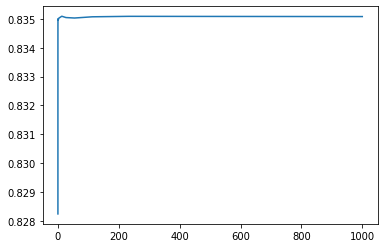

Best C value: 12.742749857031322 , with index: 13
CPU times: user 46.4 s, sys: 1min 21s, total: 2min 7s
Wall time: 2min 9s


In [108]:
%%time

curve = []
reg_strength = np.logspace(-3,3,num=20)

for c in reg_strength:

    log_reg = Pipeline([('transformer',log_reg_ct),('log_reg',LogisticRegression(C=c))])

    log_reg_cv = cross_val_score(log_reg,X_train,y_train,cv=10,n_jobs=-1,scoring='roc_auc')
    
    curve.append(log_reg_cv.mean())

sns.lineplot(x=reg_strength,y=curve)
plt.show()
print('Best C value:',reg_strength[np.argmax(np.array(curve))],', with index:',np.argmax(np.array(curve)))

In [109]:
c = 0.1623776739188721

log_reg = Pipeline([('transformer',log_reg_ct),
                    ('log_reg',LogisticRegression(C=c))])

log_reg_cv = cross_val_score(log_reg,X_train,y_train,cv=10,n_jobs=-1,scoring='roc_auc')

In [110]:
log_reg_cv.mean(),log_reg_cv.std()

(0.8349575052407493, 0.018866823546159716)

Обучим еще раз с лучшим значением.

**Desicion Tree**

Здесь нужен только `OHE`.

In [111]:
tree_ct = ColumnTransformer([('ohe',OneHotEncoder(),cat_features)],
                            remainder='passthrough')

tree = Pipeline([('transformer',log_reg_ct),('log_reg',DecisionTreeClassifier())])


tree_cv = cross_val_score(tree,X_train,y_train,cv=10,n_jobs=-1,scoring='roc_auc')

In [112]:
tree_cv

array([0.67344633, 0.65467312, 0.67737692, 0.69558515, 0.63344633,
       0.62462421, 0.66302387, 0.60916197, 0.6536149 , 0.69509401])

In [113]:
tree_cv.mean(),tree_cv.std()

(0.6580046801111527, 0.027495779233065096)

**Catboost**

Здесь категориальные признаки отдадим катбусту как есть.

In [114]:
cb_cv = cb.cv(cb.Pool(X_train,y_train,cat_features=cat_features),{"loss_function": "Logloss",'eval_metric':'AUC'},nfold=10,plot=False,verbose=0,stratified=True,)

iteritems is deprecated and will be removed in a future version. Use .items instead.


Training on fold [0/10]

bestTest = 0.8524132365
bestIteration = 434

Training on fold [1/10]

bestTest = 0.8234543987
bestIteration = 387

Training on fold [2/10]

bestTest = 0.8608232446
bestIteration = 298

Training on fold [3/10]

bestTest = 0.8609362389
bestIteration = 420

Training on fold [4/10]

bestTest = 0.8461824052
bestIteration = 428

Training on fold [5/10]

bestTest = 0.8390236768
bestIteration = 456

Training on fold [6/10]

bestTest = 0.8560540813
bestIteration = 17

Training on fold [7/10]

bestTest = 0.8192144563
bestIteration = 157

Training on fold [8/10]

bestTest = 0.858442888
bestIteration = 216

Training on fold [9/10]

bestTest = 0.8261696215
bestIteration = 350



In [115]:
cb_cv

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.791695,0.022377,0.674800,0.001184,0.674611,0.000804
1,1,0.814533,0.018122,0.657816,0.001718,0.657326,0.001287
2,2,0.819727,0.019606,0.641481,0.002526,0.641185,0.001757
3,3,0.820859,0.017777,0.627956,0.003082,0.627513,0.002529
4,4,0.821155,0.018034,0.614764,0.003673,0.614331,0.003019
...,...,...,...,...,...,...,...
995,995,0.836280,0.016701,0.430654,0.021888,0.279320,0.003742
996,996,0.836260,0.016649,0.430662,0.021859,0.279197,0.003741
997,997,0.836250,0.016587,0.430653,0.021864,0.279103,0.003729
998,998,0.836262,0.016639,0.430683,0.021920,0.279002,0.003727


In [116]:
max_auc_id = cb_cv['test-AUC-mean'].argmax()

In [117]:
cb_mean = cb_cv.loc[max_auc_id,'test-AUC-mean']
cb_std = cb_cv.loc[max_auc_id,'test-AUC-std']
display(cb_cv.loc[max_auc_id])
print()
print(max_auc_id,cb_mean,cb_std)

iterations            298.000000
test-AUC-mean           0.842735
test-AUC-std            0.016247
test-Logloss-mean       0.419160
test-Logloss-std        0.018260
train-Logloss-mean      0.372266
train-Logloss-std       0.002980
Name: 298, dtype: float64


298 0.8427353787152445 0.01624699056296969


**Neural Network**

Здесь разделим тренировочную выборку на тренировочную о валидационную и применим `OHE` и `StandartScaler`.

In [118]:
X_train_nn,X_val_nn,y_train_nn,y_val_nn = train_test_split(X_train,y_train,random_state=RAND_STATE,test_size=0.2,stratify=y_train)

Воспользуемся трансформером логистической регрессии.

In [119]:
X_train_nn = log_reg_ct.fit_transform(X_train_nn)
X_val_nn = log_reg_ct.transform(X_val_nn)

In [120]:
y_train_nn = y_train_nn.values
y_val_nn = y_val_nn.values

In [123]:
class CustomDataset(Dataset):
    
    def __init__(self,X,y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,idx):
        X = self.X[idx]
        y = self.y[idx]
        return X,y
    
dataset_train = CustomDataset(X_train_nn,y_train_nn)
dataset_val = CustomDataset(X_val_nn,y_val_nn)

train_dataloader = DataLoader(dataset_train,batch_size=32,shuffle=True)
val_dataloader = DataLoader(dataset_val,batch_size=32,shuffle=False)

Сделаем класс с 4 слоями, везде `ReLU`.

In [124]:
class NeuralN(nn.Module):
    
    def __init__(self, n_in,n_1,n_2,n_3,n_out):
        
        super(NeuralN,self).__init__()
        
        self.f1 = nn.Linear(n_in,n_1)
        self.a1 = nn.ReLU()
        
        self.f2 = nn.Linear(n_1,n_2)
        self.a2 = nn.ReLU()
        
        self.f3 = nn.Linear(n_2,n_3)
        self.a3 = nn.ReLU()
        
        self.f4 = nn.Linear(n_3,n_out)
        
        self.init_weights()
        
    def forward(self, x):
        x = self.a1(self.f1(x))
        x = self.a2(self.f2(x))
        x = self.a3(self.f3(x))
        x = self.f4(x)
        return x
        
    def init_weights(m):
        if isinstance(m,nn.Linear):
            nn.init.kaiming_normal(m.weight)
            m.bias.data.fill_(0.01)
    

In [125]:
def model_train_and_evaluate(model,train_dataloader,val_dataloader,loss_fn,optimizer,steps=500):
    model.to(device)
    
    with tqdm(total=steps) as pbar:
        
        aucroc = AUROC().to(device)
        aucroc_val = AUROC().to(device)
        
        for steps in range(steps):
            model.train()
            
            total_loss = []
            
            for X,y in train_dataloader:
                X = X.to(device).float()
                y_true = y.to(device).float().unsqueeze(1)
                
                y_pred = model(X)
                
                loss = loss_fn(y_pred,y_true)
                
                optimizer.zero_grad()
                
                loss.backward()
                
                optimizer.step()
                
                total_loss.append(loss.item())
                
                auc_value = aucroc(y_pred,y_true.int())
                
                
            
            model.eval()
            
            total_eval_loss = []
            
            with torch.inference_mode():
                for X,y in val_dataloader:
                    X = X.to(device).float()
                    y_true = y.to(device).float().unsqueeze(1)
                    
                    eval_pred = model(X)
                    
                    eval_loss = loss_fn(eval_pred,y_true)
                    
                    total_eval_loss.append(eval_loss.item())
                    
                    auc_val_value = aucroc_val(eval_pred,y_true.int())
                
            pbar.update(1)
            pbar.set_description(f'train loss: {loss.item():.2f}, auc:{aucroc.compute().item():.2f}, val loss: {eval_loss.item():.2f}, auc:{aucroc_val.compute().item():.2f}')
            
    return aucroc_val.compute().item()

            

In [126]:
n_in, n_1, n_2, n_3,n_out = X_train_nn.shape[-1], 40, 20, 10, 1

loss_fn = nn.BCEWithLogitsLoss()
model_base = NeuralN(n_in, n_1, n_2, n_3, n_out)
optimizer = torch.optim.Adam(model_base.parameters(), lr = 1e-3)

epochs = 5

nn_auc = model_train_and_evaluate(model_base,train_dataloader,val_dataloader,loss_fn,optimizer,steps=epochs)

  0%|          | 0/5 [00:00<?, ?it/s]Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
train loss: 0.38, auc:0.81, val loss: 0.23, auc:0.83: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


**Сравнение моделей**

In [127]:
cv_comparison = pd.DataFrame([[log_reg_cv.mean(),log_reg_cv.std()],
                              [tree_cv.mean(),tree_cv.std()],
                             [cb_mean,cb_std],
                             [nn_auc,np.NaN]],
                             index=['log_reg','tree','catboost','nn'],
                             columns=['auc_mean','auc_std'])
cv_comparison

,auc_mean,auc_std
log_reg,0.834958,0.018867
tree,0.658005,0.027496
catboost,0.842735,0.016247
nn,0.825459,NaN


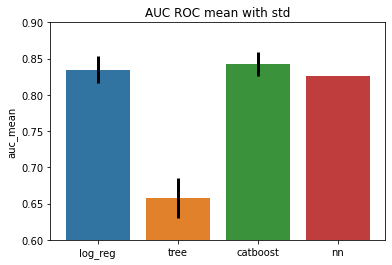

In [128]:
ax = sns.barplot(data=cv_comparison,y='auc_mean',x=cv_comparison.index)
ax.errorbar(data=cv_comparison, x=cv_comparison.index, y='auc_mean', yerr='auc_std', ls='', lw=3, color='black')
plt.title('AUC ROC mean with std')
plt.ylim(0.6,0.9)
plt.show()

Все модели кроме дерева выдают примерно одинаковый скор, но будем работать с катбустом, потому что у него меньше стандартное отклонение, что говорит о лучшей обощающей способности модели, и хотя логистическую регрессию проще интерпретировать, но, мне кажется, что катбуст при оптимизации гиперпараметров и новых фичах может выдать больший скор.

## Catboost - оптимизация гиперпараметров

Гиперпараметры будем оптимизировать с помощью `optuna`.

In [129]:
def objective(trial):

    param = {
        "depth": trial.suggest_int("depth", 2, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000, log=True),
        'loss_function':'Logloss',
        'eval_metric':'AUC'
    }
    
    cb_cv = cb.cv(cb.Pool(X_train,y_train,cat_features=cat_features),param,nfold=10,plot=False,stratified=True,verbose=False)
    return cb_cv['test-AUC-mean'].values[-1]
    

Ограничимся 100 попытками и 20 минутами.

In [130]:
%%time
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1, timeout=1200, n_jobs=1)

[I 2022-11-03 22:53:19,296] A new study created in memory with name: no-name-83791eac-b445-4a95-a041-3c210c95c877
iteritems is deprecated and will be removed in a future version. Use .items instead.


Training on fold [0/10]

bestTest = 0.8295480226
bestIteration = 10

Training on fold [1/10]

bestTest = 0.8020500404
bestIteration = 134

Training on fold [2/10]

bestTest = 0.8381840194
bestIteration = 4

Training on fold [3/10]

bestTest = 0.8393381759
bestIteration = 142

Training on fold [4/10]

bestTest = 0.8153510896
bestIteration = 140

Training on fold [5/10]

bestTest = 0.823959569
bestIteration = 130

Training on fold [6/10]

bestTest = 0.837601768
bestIteration = 142

Training on fold [7/10]

bestTest = 0.7919625591
bestIteration = 142

Training on fold [8/10]

bestTest = 0.8249020914
bestIteration = 137

Training on fold [9/10]


[I 2022-11-03 22:53:30,505] Trial 0 finished with value: 0.8202785749494884 and parameters: {'depth': 5, 'learning_rate': 0.001686168467008869, 'n_estimators': 143}. Best is trial 0 with value: 0.8202785749494884.



bestTest = 0.8098136081
bestIteration = 12

CPU times: user 6.01 s, sys: 411 ms, total: 6.42 s
Wall time: 11.2 s


In [131]:
print('Best params:',study.best_params)
print('Best score:',study.best_value)

Best params: {'depth': 5, 'learning_rate': 0.001686168467008869, 'n_estimators': 143}
Best score: 0.8202785749494884


## Исследуем модель и важность признаков

Обучим бустинг на всех тренировочных данных с использованием лучших гиперпараметров.

In [132]:
# Обучим модель на уже подобранных гиперпараметрах
params = {'depth': 3, 
          'learning_rate': 0.059083618990867975, 
          'n_estimators': 282, 
          'loss_function': 'Logloss', 
          'eval_metric': 'AUC'}

# params = study.best_params
catboost = CatBoostClassifier(**params,verbose=0,cat_features = cat_features)
catboost.fit(X_train,y_train)

Построим матрицу ошибок.

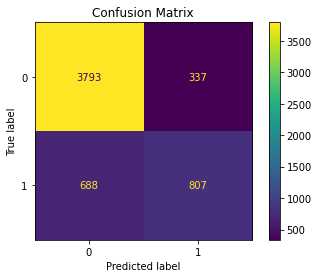

In [133]:
cm = confusion_matrix(y_train,catboost.predict(X_train),labels=catboost.classes_)
ConfusionMatrixDisplay(cm,display_labels=catboost.classes_).plot()
plt.title('Confusion Matrix')
plt.show()

Модель почти в 2 раза чаще ошибается ложно отрицательно, чем ложно положительно.

Построим график точности и полноты

In [134]:
predict_proba = catboost.predict_proba(X_train)[:,1]


iteritems is deprecated and will be removed in a future version. Use .items instead.


In [135]:
thresholds = []
recall = []
precision = []

for threshold in range(101):
    threshold /= 100
    thresholds.append(threshold)
    pred = list(map(int,predict_proba > threshold))
    recall.append(recall_score(y_train,pred,zero_division=0))
    precision.append(precision_score(y_train,pred,zero_division=0))
    

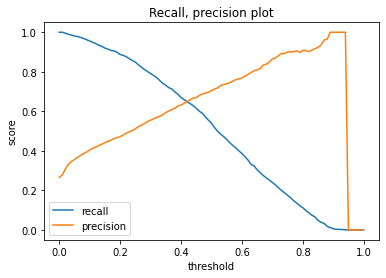

In [136]:
sns.lineplot(x=thresholds,y=recall,label='recall')
sns.lineplot(x=thresholds,y=precision,label='precision')
plt.title('Recall, precision plot')
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.show()

Оптимальное значение threshold находится примерно в 0.45, но его можно подобрать точнее при необходимости.

Исследуем важность признаков

In [137]:
explainer = shap.TreeExplainer(catboost)
shap_values = explainer.shap_values(X_train)

iteritems is deprecated and will be removed in a future version. Use .items instead.


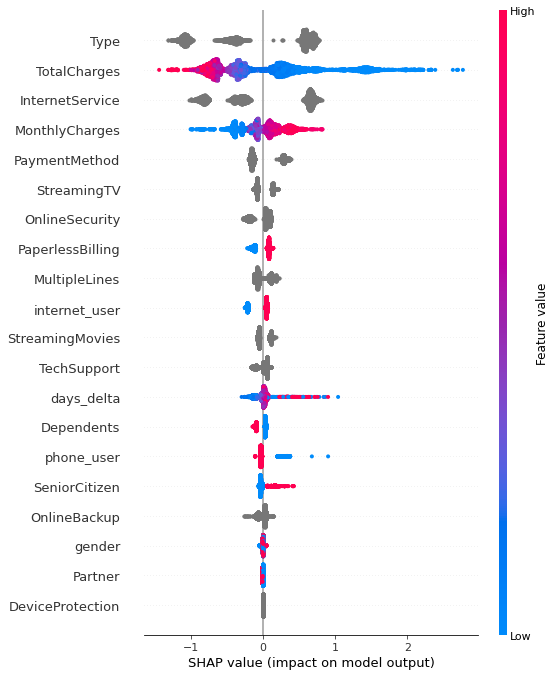

In [138]:
shap.summary_plot(shap_values, X_train)

Обратим внимание на 3 топовых признака: `'Type'`,`'TotalCharges'`,`'InternetService'`

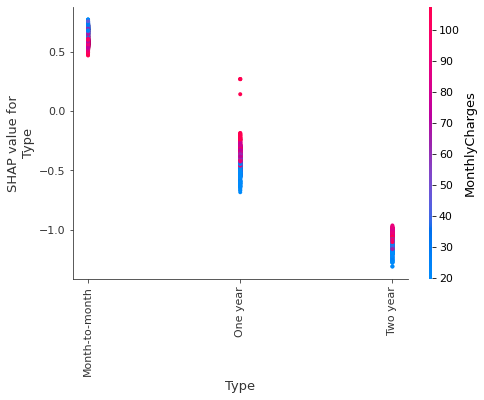

In [139]:
shap.dependence_plot("Type", shap_values, X_train)

Здесь мы видим, что ежемесячные платежи сильнее всего положительно влияют на отнесению к классу оттока.

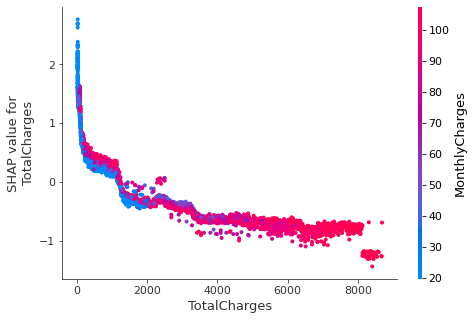

In [140]:
shap.dependence_plot("TotalCharges", shap_values, X_train)

Здесь мы видим, что при TotalCharges выше где-то 1100 - влияние на отнесение к классу оттока начинает падать.

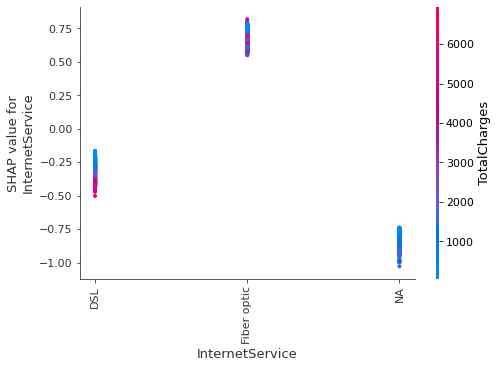

In [141]:
shap.dependence_plot("InternetService", shap_values, X_train)

А здесь, что оптоволоконное соединение почти всегда увеличивает "вероятность" отнесения к классу оттока.

Исследуем графически зависимость `'Type'` и `'TotalCharges'` от `'churned'`

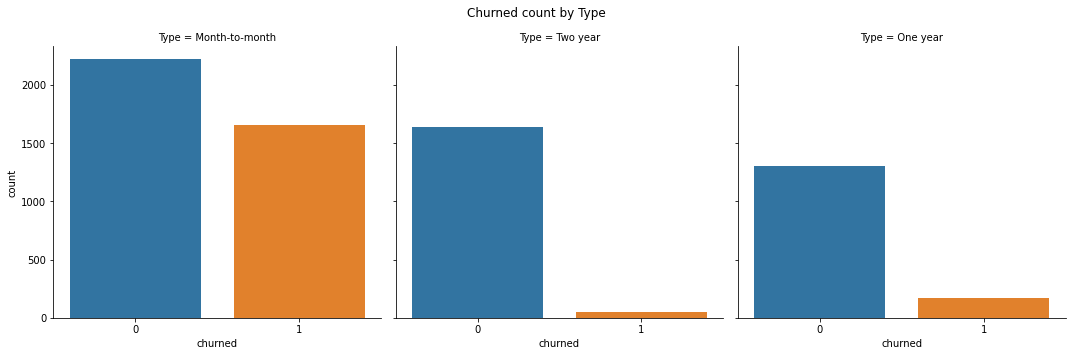

In [142]:
ax = sns.catplot(kind='count',data=df,x='churned',col='Type')
ax.fig.subplots_adjust(top=0.87)
ax.fig.suptitle('Churned count by Type')
plt.show()

Значительный перевес в классе ежемесячных платежей. Здесь доля оттока в несколько раз выше, чем в других классах.

In [143]:
min_max_dates = df[['BeginDate','EndDate']].describe(datetime_is_numeric=True).loc[['min','max']].T
min_max_dates.loc['EndDate','max'] - min_max_dates.loc['BeginDate','min']

Timedelta('624 days 00:00:00')

У нас весь период это 624 дня, меньше 2х лет. Репрезентативен ли этот период для двухгодовых и годовых контрактов? Я думаю, что нет.  
У помесячной оплаты было на порядок больше возможностей уйти в отток, чем у годовых и двухгодовых.

С другой стороны у нас всего 4 даты оттока.

In [144]:
df['EndDate'].value_counts()

2019-11-01    485
2019-12-01    466
2020-01-01    460
2019-10-01    458
Name: EndDate, dtype: int64

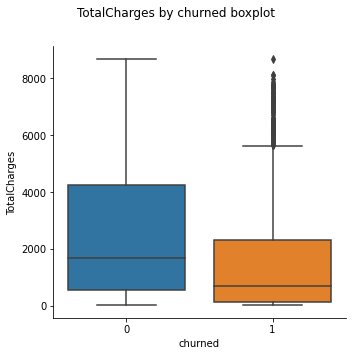

In [145]:
ax = sns.catplot(kind='box',data=df,x='churned',y='TotalCharges')
ax.fig.subplots_adjust(top=0.87)
ax.fig.suptitle('TotalCharges by churned boxplot')
plt.show()

Здесь мы видим похожую картину, что в `shap.dependance_plot`: распределение группы оттока по TotalCharges в среднем меньше и диапазон меньше.

Посмотрим TotalCharges по группам оттока в каждом типе оплаты.

Сначала выведем график кол-ва, а затем бокплот TotalCharges.

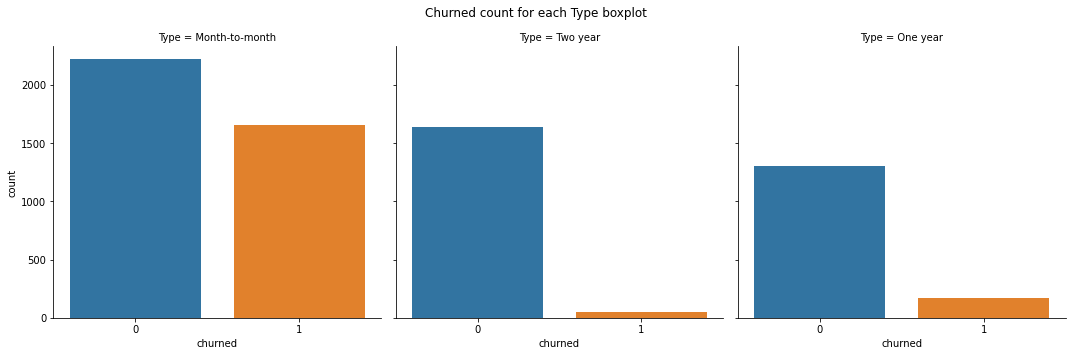

In [146]:
ax = sns.catplot(kind='count',data=df,x='churned',
                 # hue='TotalCharges',
                 col='Type')
ax.fig.subplots_adjust(top=0.87)
ax.fig.suptitle('Churned count for each Type boxplot')
plt.show()

In [147]:
df.groupby('Type')['churned'].value_counts().to_frame()

churned
Type           churned         
Month-to-month 0           2220
               1           1655
One year       0           1306
               1            166
Two year       0           1637
               1             48

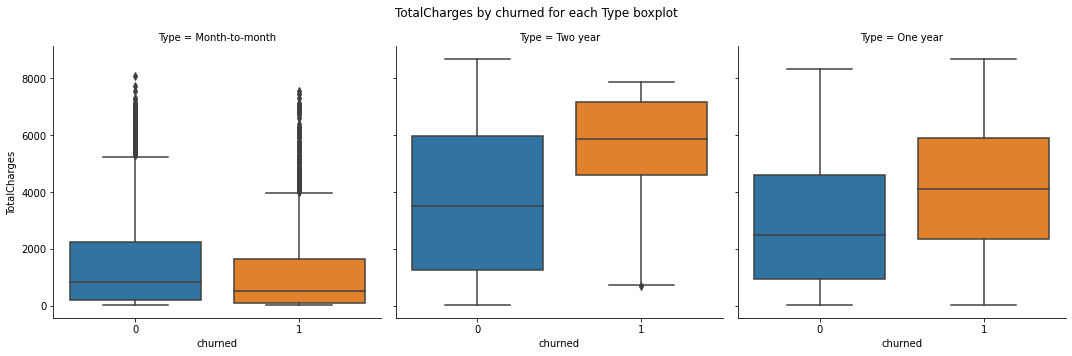

In [148]:
ax = sns.catplot(kind='box',data=df,x='churned',y='TotalCharges',col='Type')
ax.fig.subplots_adjust(top=0.87)
ax.fig.suptitle('TotalCharges by churned for each Type boxplot')
plt.show()

В двухгодовых и годовом типе оплаты кол-во оттока значительно меньше, что не позволяет полагаться на распределени оттока в этих группах, в отличие от помесячной оплаты.

## **Проверим ROC AUC на тестовых данных**

In [149]:
pred = catboost.predict_proba(X_test)[:,1]

roc_auc_score(y_test,pred)

iteritems is deprecated and will be removed in a future version. Use .items instead.


0.8598210911575752

## Вывод

**Задача**: предсказание оттока пользователей телеком компании.  
**Данные**: 4 таблицы с информацией о контрактах, личных характеристиках пользователей, интернет услугах и телефонии.  
**Период**: С 2018-04-17 по 2020-02-01.

Было протестировано 4 модели:
- логистическая регрессия
- дерево решений
- градиентный бустинг
- нейронная сеть

Метрика качества: `auc roc`

Лучший результат показал градиентный бустинг: auc_roc на тестовой выборке: `0.86`

Наиболее важными признаками модель выбрала:
* `'Type'` - тип оплаты контракта (помесячный, годовой и двухгодовой),
* `'TotalCharges'` (общее объем платежей),
* `'InternetService'` (тип подключения к интернет)

Говоря о типе оплата контракта, предоставленные данные могут быть нерепрезентативны для годовой и двухгодовой оплат, т.к. период составляет чуть меньше двух лет и у этих категорий было значительно меньше возможностей уйти в отток в отличие от помесячной оплаты.

